In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score


# Cargar los datos
Los CSV vienen sin cabecera, así que es necesario añadir los nombres de las columnas.

In [2]:
large_training_file = "data/KDDTrain+.txt"
small_training_file = "data/KDDTrain+_20Percent.txt"

df = pd.read_csv(large_training_file, header=None)

# Las columnas según la documentacion son estas:
col_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","TARGET","labels"]

# El target (lo que queremos predecir) es este:
target = "TARGET"

df.columns = col_names

df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,TARGET,labels
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


## Separar Features de Target

In [3]:
X = df[col_names].drop(target, axis=1)
y = df[target]

display(X.head())
print(X.shape)

display(y.head())
print(y.shape)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,20
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21


(125973, 42)


0     normal
1     normal
2    neptune
3     normal
4     normal
Name: TARGET, dtype: object

(125973,)


In [4]:
y.unique()

array(['normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep',
       'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back',
       'guess_passwd', 'ftp_write', 'multihop', 'rootkit',
       'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land',
       'loadmodule', 'spy', 'perl'], dtype=object)

# Analisis preliminar
## ¿Hay nulos?
Buscar y reemplazar valores nulos.

Como se ve, con *.info()* **no hay valores nulos**.

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [6]:
# Visualización de los datos
#h = 30
#w = 20
#X.hist(bins=50, figsize=(h, w))
#plt.show();

## ¿Esta balanceado el dataset?
No está balanceado: en el dataset grande "spy" solo sale dos veces, mientras que "netpune" sale más de 40000 y el tráfico normal más de 67000.

In [7]:
y.value_counts()

normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: TARGET, dtype: int64

Por eso voy a **normalizar** los "target" agrupándo según el tipo ataque que es (i.e. 'spy': 'R2L'; 'loadmodule': 'U2R'; 'mailbomb': 'DoS'; etc.)

Si comparamos tráfico normal vs tráfico que indica un ataque vemos que el dataset está más balanceado:

In [8]:
filter_normal_trafic = y=="normal"

print(f"Trafico normal: {y[filter_normal_trafic].count()} vs Trafico no normal: {y[~filter_normal_trafic].count()}")

Trafico normal: 67343 vs Trafico no normal: 58630


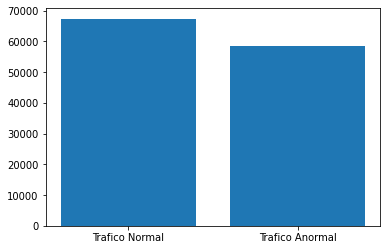

In [9]:
plt.bar(['Trafico Normal', 'Trafico Anormal'], [y[filter_normal_trafic].count(), y[~filter_normal_trafic].count()])
plt.show();

### Normalizo los tipos de ataque del dataset
Estos datos los saco de la documentación del dataset

In [10]:
attack_dict = {'normal': 'normal', 
               
               'back': 'DoS',
               'land': 'DoS',
               'neptune': 'DoS',
               'pod': 'DoS',
               'smurf': 'DoS',
               'teardrop': 'DoS',
               'mailbomb': 'DoS',
               'apache2': 'DoS',
               'processtable': 'DoS',
               'udpstorm': 'DoS',
               
               'ipsweep': 'Probe',
               'nmap': 'Probe',
               'portsweep': 'Probe',
               'satan': 'Probe',
               'mscan': 'Probe',
               'saint': 'Probe',
               
               'ftp_write': 'R2L',
               'guess_passwd': 'R2L',
               'imap': 'R2L',
               'multihop': 'R2L',
               'phf': 'R2L',
               'spy': 'R2L',
               'warezclient': 'R2L',
               'warezmaster': 'R2L',
               'sendmail': 'R2L',
               'named': 'R2L',
               'snmpgetattack': 'R2L',
               'snmpguess': 'R2L',
               'xlock': 'R2L',
               'xsnoop': 'R2L',
               'worm': 'R2L',
               
               'buffer_overflow': 'U2R',
               'loadmodule': 'U2R',
               'perl': 'U2R',
               'rootkit': 'U2R',
               'httptunnel': 'U2R',
               'ps': 'U2R',
               'sqlattack': 'U2R',
               'xterm': 'U2R'
              }

y_normalized = pd.Series([attack_dict[t] for t in y])

print(y.shape)
print(y_normalized.shape)

display(y.head())
print("---")
display(y_normalized.head())

(125973,)
(125973,)


0     normal
1     normal
2    neptune
3     normal
4     normal
Name: TARGET, dtype: object

---


0    normal
1    normal
2       DoS
3    normal
4    normal
dtype: object

### Dentro del dataset, ¿están balanceados los ataques en el dataset?
El dataset lo divido en tráfico normal y anómalo. Dentro del tráfico anómalo hay una serie de subcategorías. ¿Están balanceadas estas subcategorías?

Por desgracia no lo está como puede verse a continuación. Está muy descompensado hacia el tipo *DoS*.

In [11]:
y_normalized[~filter_normal_trafic].value_counts()

DoS      45927
Probe    11656
R2L        995
U2R         52
dtype: int64

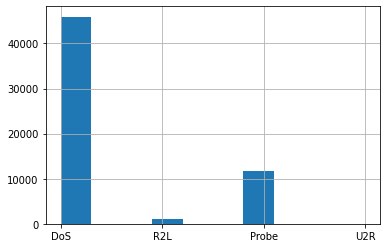

In [12]:
y_normalized[~filter_normal_trafic].hist()
plt.show()

## Variables Numéricas y Categóricas

In [13]:
# Columnas con valores numericos
X_numeric = X.select_dtypes(include=np.number)

# Columnas con valores categoricos
X_categoric = X.select_dtypes(exclude=np.number)

### Posibles valores en datos categóricos

In [14]:
for c in X_categoric.columns.to_list():
    print(f"La columna '{c}' tiene estos valores:\n{X_categoric[c].unique()}\n")

La columna 'protocol_type' tiene estos valores:
['tcp' 'udp' 'icmp']

La columna 'service' tiene estos valores:
['ftp_data' 'other' 'private' 'http' 'remote_job' 'name' 'netbios_ns'
 'eco_i' 'mtp' 'telnet' 'finger' 'domain_u' 'supdup' 'uucp_path' 'Z39_50'
 'smtp' 'csnet_ns' 'uucp' 'netbios_dgm' 'urp_i' 'auth' 'domain' 'ftp'
 'bgp' 'ldap' 'ecr_i' 'gopher' 'vmnet' 'systat' 'http_443' 'efs' 'whois'
 'imap4' 'iso_tsap' 'echo' 'klogin' 'link' 'sunrpc' 'login' 'kshell'
 'sql_net' 'time' 'hostnames' 'exec' 'ntp_u' 'discard' 'nntp' 'courier'
 'ctf' 'ssh' 'daytime' 'shell' 'netstat' 'pop_3' 'nnsp' 'IRC' 'pop_2'
 'printer' 'tim_i' 'pm_dump' 'red_i' 'netbios_ssn' 'rje' 'X11' 'urh_i'
 'http_8001' 'aol' 'http_2784' 'tftp_u' 'harvest']

La columna 'flag' tiene estos valores:
['SF' 'S0' 'REJ' 'RSTR' 'SH' 'RSTO' 'S1' 'RSTOS0' 'S3' 'S2' 'OTH']



### Separo columnas categóricas de numéricas en dos variables

In [15]:
numerical_features = X_numeric.columns.to_list()
categorical_features = X_categoric.columns.to_list()

In [16]:
numerical_features

['duration',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'labels']

In [17]:
categorical_features

['protocol_type', 'service', 'flag']

## ¿Buscar outliers?
Utilizando la librería https://pyod.readthedocs.io/en/latest/ para hacer un análisis más complejo que símplemente usar cuartiles junto con histogramas, box-plots y scatter plots.

Outliers son valores extremos. Tener outliers puede tener un impacto significativo en los resultados de un modelo de machine learning.

Sin embargo, los outliers no tienen que ser malos de por sí y no se deberían descartar sin pensarlo antes. Pueden ser observaciones que no siguen el mismo patrón que el resto. Por ejemplo, buscar outliers en tráfico de red puede llevar a conclusiones interesantes, ¿por qué hay tráfico anómalo desde una de nuestras IPs a una red externa?

Los outliers pueden clasificarse en dos tipos:
- Univariate: valores extremos en solo una variable.
- Multivariate: valores extremos combinando más de una variable.

Voy a probar a la aproximación *Unsupervised Outlier Detection* ya que no dispongo de un set de datos con *labels* que me digan qué filas corresponden a *otuliers*. 

Voy a utilizar el algoritmo *ABOD* (*Angle-Based Outlier Detection*) ya que funciona bien para datos multidimensionales.
[DUDA] ¿Usar LOCI en vez? Según la documentación es muy eficaz y proporciona un solo número como salida para cada punto


```python
import seaborn as sns

from pyod.models.cblof import CBLOF
```

```python
# Escalado con standar scaler antes de entrenar el algoritmo de CBLOF
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[numerical_features])
```

```python
# Entrenar Clasificador CBLOF
outliers_fraction = 0.01

clf = CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=0)

clf.fit(X_scaled)
#scores_pred = clf.decision_function(X_scaled) * -1
y_pred = clf.predict(X_scaled)
```

```python
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)

print(n_inliers)
print(n_outliers)
```

```python
X['outlier'] = y_pred.tolist()
```

```python
X['outlier'].value_counts()
```

```python
X.shape
```

```python
X_aux = pd.concat([X, y], axis=1)
X_aux.shape
```

```python
is_outlier = X['outlier'] == 1

X_aux = X_aux[~is_outlier]
X_aux.drop('outlier', axis=1, inplace=True)
```

```python
X_aux.shape
```

```python
X = X_aux[col_names].drop(target, axis=1)
y = X_aux[target]

display(X.head())
print(X.shape)

display(y.head())
print(y.shape)
```

```python
# También toca normalizar y (para reducir el número de labels que hay según el diccionario de arriba)
y_normalized = pd.Series([attack_dict[t] for t in y])
```

Como también hay que hablar de los fracasos, he intentado hacer una búsqueda de outliers como describo arriba y los resultados no han sido positivos:
- **Sin eliminar outliers** los resultados son estos:
    - La accuracy media de la validación es: 0.83
    - La accuracy media con los datos de test es: 0.69

- **Eliminando outliers** los resultados son estos:
    - La accuracy media de la validación es: 0.65
    - La accuracy media de los datos de test es: 0.67

¿Estos resultados tienen sentido? En mi opinión sí, ya que al fin y al cabo lo que estamos haciendo es separar eventos clasificados como normales de los anómalos. Que un evento presente datos que están fuera del uso normal de la infraestructura puede ser un buen indicador de un ataque.

# Pasos para aplicar Machine Learning
En resumen sigo un proceso típico de Machine Learning:
- pasar datos categóricos a valores numéricos.
- normalizar esos valores numéricos.
- crear y entrenar algoritmos
- predicciones (a.k.a. análisis de eventos en busca de posibles ataques).

## Transformaciones
Para automatizar esta tarea utilizo Column Transformer
- Valores numéricos: les aplico Standard Scaler para normalizarlos.
- Valores categóricos: les aplico One Hot encoder para transformarlos en valores numéricos.

In [18]:
preprocessor = ColumnTransformer(transformers=[('numerical', StandardScaler(), numerical_features),
                                               ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

In [19]:
preprocessor

ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                 ['duration', 'src_bytes', 'dst_bytes', 'land',
                                  'wrong_fragment', 'urgent', 'hot',
                                  'num_failed_logins', 'logged_in',
                                  'num_compromised', 'root_shell',
                                  'su_attempted', 'num_root',
                                  'num_file_creations', 'num_shells',
                                  'num_access_files', 'num_outbound_cmds',
                                  'is_host_login', 'is_guest_login', 'count',
                                  'srv_count', 'serror_rate', 'srv_serror_rate',
                                  'rerror_rate', 'srv_rerror_rate',
                                  'same_srv_rate', 'diff_srv_rate',
                                  'srv_diff_host_rate', 'dst_host_count',
                                  'dst_host_srv_count', ...]),
             

In [20]:
X_transformed = pd.DataFrame(data=preprocessor.fit_transform(X))
X_transformed.head()

,0,1,2,3,4,5,6,7,8,9,...,113,114,115,116,117,118,119,120,121,122
0,-0.110249,-0.007679,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.110249,-0.007737,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.110249,-0.007723,-0.002891,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,1.235694,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.110249,-0.007728,-0.004814,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,1.235694,-0.011664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Machine Learning
- crear y entrenar algoritmos
- predicciones (a.k.a. análisis de eventos en busca de posibles ataques).

## Selección del modelo
Utilizo *pipelines* para automatizar el preprocesado de datos con el *ColumnEncoder* que he creado en el paso anterior.

In [21]:
ml_model = LGBMClassifier()

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('ml_classifier', ml_model)])

## Validación cruzada
Para valorar de forma más precisa cómo de bien se comportan las predicciones del modelo.

```python
scores = cross_val_score(model, 
                         X, 
                         y_normalized, 
                         scoring='accuracy', 
                         cv=10, 
                         n_jobs=-1)
```

```python
print(f"La media de la validación es: {round(np.mean(scores), 2)}")
```

**Nota**: este apartado lo he dejado como muestra de utilzación de la validación cruzada. Realmente en el siguiente paso hago optimización de hiperparámetros usando *RandomizedSearchCV* y, por tanto, la validación cruzada queda cubierta.

## Optimización de hiperparámetros
Utilizo *RandomizedSearchCV* para probar el modelo con distintas combinaciones de hiperparámetros.

**Nota**: el código de esta parte está desactivado para evitar lanzarlo por error, ya que tardó varias horas en terminar.

### Optimización usando *accuracy* como métrica:

```python
param_grid = {
    'ml_classifier__n_estimators': [16, 32, 64, 128, 256, 512],
    'ml_classifier__boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
    'ml_classifier__num_leaves': [4, 8, 16, 31, 64, 70, 80],
}

grid_search = RandomizedSearchCV(model, 
                                 param_grid, 
                                 cv=5, 
                                 verbose=10, 
                                 scoring='accuracy', 
                                 n_jobs=-1,
                                 n_iter=32)

grid_search.fit(X, y)
```

### Optimización usando *AUC ROC* como métrica:

```python
from sklearn.model_selection import StratifiedKFold

param_grid = {
    'ml_classifier__n_estimators': [16, 32, 64, 128, 256, 512],
    'ml_classifier__boosting_type': ['gbdt', 'dart', 'goss'],
    'ml_classifier__num_leaves': [4, 8, 16, 31, 64, 70, 80],
}

grid_search = RandomizedSearchCV(model, 
                                 param_grid, 
                                 cv=StratifiedKFold(n_splits=2),
                                 verbose=10, 
                                 scoring='roc_auc_ovr_weighted', 
                                 n_jobs=-1,
                                 n_iter=32)

grid_search.fit(X, y)
```

### ¿Cuales son los parámetros que dan mejor resultado?

```python
grid_search.best_params_
```

Los parámetros con los que se consigue mejores resultados para **accuracy** son estos:
- 'num_leaves': 70,
- 'n_estimators': 16,
- 'boosting_type': 'goss'

Los parámetros con los que se consigue mejores resultados para **roc auc one-vs-rest (weighted)** son estos:
- 'num_leaves': 64,
- 'n_estimators': 16,
- 'boosting_type': 'dart'

## Predicción
Ahora hay que usar el modelo con los datos de test y los parámetros optimizados para ver como se comporta.

```python
test_file = "data/KDDTest+.txt"
test_df = pd.read_csv(large_training_file, header=None)

# Le pongo las mismas columnas que el dataframe de entrenamiento
test_df.columns = df.columns

# Separo las labels del target
X_test = test_df[col_names].drop(target, axis=1)
y_test = test_df[target]
```

```python
# Predicción usando el modelo ya entrenado con RandomizedSearchCV
y_predict = grid_search.predict(X_test)
```

```python
# Y vemos el resultado de la predicción con los datos de test
scores = precision_score(y_test, 
                y_predict, 
                average="micro")

# Nota:
# El parámetro "average" es necesario para evaluar la precisión con un problema de clasificación multiclase. Ver la documentación:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html

print(f"La media con los datos de test es: {round(np.mean(scores), 2)}")
```

### Resultado
La media de acuracy con los datos de validación tras la optimización de hiperparámetros es **sorprendetemente buena**: 0.94

## Entrenamiento
Una vez he analizado varios modelos entreno el que ha dado mejores resultados usando todos los datos del dataset.

También he aplicado los hiperparámetros que he sacado en el paso anterior.

In [22]:
ml_model = LGBMClassifier(num_leaves=70,
                          n_estimators=16,
                          boosting_type='goss')

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('ml_classifier', ml_model)])

In [23]:
model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['duration', 'src_bytes',
                                                   'dst_bytes', 'land',
                                                   'wrong_fragment', 'urgent',
                                                   'hot', 'num_failed_logins',
                                                   'logged_in',
                                                   'num_compromised',
                                                   'root_shell', 'su_attempted',
                                                   'num_root',
                                                   'num_file_creations',
                                                   'num_shells',
                                                   'num_access_files',
                                                   'num_outbound_cmds',
                     

## Predicción
Paso los datos de test por el modelo y compruebo los resultados.

In [24]:
test_file = "data/KDDTest+.txt"
test_df = pd.read_csv(large_training_file, header=None)

# Le pongo las mismas columnas que el dataframe de entrenamiento
test_df.columns = df.columns

# Separo las labels del target
X_test = test_df[col_names].drop(target, axis=1)
y_test = test_df[target]

In [25]:
# Predicción usando el modelo ya entrenado en el paso anterior
y_predict = model.predict(X_test)

In [26]:
# Y vemos el resultado de la predicción con los datos de test
scores = precision_score(y_test, 
                y_predict, 
                average="micro")

# Nota:
# El parámetro "average" es necesario para evaluar la precisión con un problema de clasificación multiclase. Ver la documentación:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html

print(f"La media con los datos de test es: {round(np.mean(scores), 2)}")

La media con los datos de test es: 0.94


La media de accuracy con los datos de test y los parámetros por defecto es: 0.69
    
La media de accuracy con los datos de test y los parámetros que ha devuelto la optimización con RandomizedSearchCV: 0.94

# [TO-DO] Probar otro método de evaluación

* Sugerencia de David: AUC one vs All (una etiqueta contra el resto)

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#plot-roc-curves-for-the-multilabel-problem

Ten en cuenta: micro-avg roc vs macro-avg roc (macro computa la métrica independiente de cada clase; El micro agrega todo de todas las clases y hace una media -en ese sentido tendría la clase que tiene más pondera el número de observaciones por cada clase-).

-----
+ hacer una matriz de confusión

-----

Calcular el AUC y curva ROC.

Ver la curva ROC de cada clase (del TARGET) y AUC.
Ver tasa de falsos positivos vs falsos negativos.

Par un proyecto real, estos temas son muy importantes: 
¿voy a tener muchos falsos positivos y voy a tirar clientes potenciales? ¿me merece la pena correr ese riesgo? (es la lucha entre seguridad vs usabilidad, al final).


Cosas para true positive, false negative, roc, etc. ver estos tutoriales:

https://www.youtube.com/watch?v=TmhzUdPpVPQ

https://www.youtube.com/watch?v=ZlGz9Nl5irs

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

https://www.kaggle.com/maria591/lightgbm

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

# Área Bajo la Curva ROC
Como método de evaluación de los resultados del algoritmo utilizo ROC AUC.

Al tratarse de un problema de clasificación multiclase voy a usar estos dos métodos de comparación:
- OVO (One-vs-One) calcula el AUC promedio de las posibles combinación de clases.
- OVR (One-vs-Rest) compara el AUC de cada clase contra el resto.

## Modelo con hiperparámetros por defecto

In [27]:
ml_model = LGBMClassifier()

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('ml_classifier', ml_model)])

model.fit(X, y)

y_prob = model.predict_proba(X_test)

In [28]:
macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")

weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="weighted")

macro_roc_auc_ovr = roc_auc_score(y_test,y_prob, multi_class="ovr",average="macro")

weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="weighted")

print(f"One-vs-One ROC AUC scores:\n{round(macro_roc_auc_ovo, 2)} (macro)\n{round(weighted_roc_auc_ovo, 2)} (weighted by prevalence)")

print("\n")

print(f"One-vs-Rest ROC AUC scores:\n{round(macro_roc_auc_ovr, 2)} (macro)\n{round(weighted_roc_auc_ovr, 2)} (weighted by prevalence)")


One-vs-One ROC AUC scores:
0.52 (macro)
0.6 (weighted by prevalence)


One-vs-Rest ROC AUC scores:
0.53 (macro)
0.78 (weighted by prevalence)


## Modelo con hiperparámetros optimizados

In [29]:
ml_model = LGBMClassifier(num_leaves=64,
                          n_estimators=16,
                          boosting_type='dart')

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('ml_classifier', ml_model)])

model.fit(X, y)

y_prob = model.predict_proba(X_test)

In [30]:
macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")

weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="weighted")

macro_roc_auc_ovr = roc_auc_score(y_test,y_prob, multi_class="ovr",average="macro")

weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="weighted")

print(f"One-vs-One ROC AUC scores:\n{round(macro_roc_auc_ovo, 2)} (macro)\n{round(weighted_roc_auc_ovo, 2)} (weighted by prevalence)")

print("\n")

print(f"One-vs-Rest ROC AUC scores:\n{round(macro_roc_auc_ovr, 2)} (macro)\n{round(weighted_roc_auc_ovr, 2)} (weighted by prevalence)")


One-vs-One ROC AUC scores:
0.56 (macro)
0.63 (weighted by prevalence)


One-vs-Rest ROC AUC scores:
0.35 (macro)
0.93 (weighted by prevalence)
